# Inverted Pendulum Problem

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    \theta & \dot{\theta}
    \end{bmatrix}
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    \tau
    \end{bmatrix}
\end{equation*}
$$

The goal is to swing the pendulum upright:

$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0
    \end{bmatrix}
\end{equation*}
$$

In order to deal with potential angle wrap-around issues (i.e. $2\pi = 0$), we
augment the state as follows and use that instead:

$$
\begin{equation*}
\textbf{x}_{augmented} = \begin{bmatrix}
    \sin\theta & \cos\theta & \dot{\theta}
    \end{bmatrix}
\end{equation*}
$$

**Note**: The torque is constrained between $-1$ and $1$. This is achieved by
instead fitting for unconstrained actions and then applying it to a squashing
function $\tanh(\textbf{u})$. This is directly embedded into the dynamics model
in order to be auto-differentiated. This also means that we need to apply this
transformation manually to the output of our iLQR at the end.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from ilqr import iLQR
from ilqr.cost import QRCost
from ilqr.dynamics import constrain
from ilqr.examples.pendulum import InvertedPendulumDynamics

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\LENOVO\Anaconda3\envs\i2dl\lib\site-packages\theano-1.0.5-py3.7.egg\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [5]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = dynamics.reduce_state(xs[-1])
    print("iteration", iteration_count, info, J_opt, final_state)

In [6]:
dt = 0.02
pendulum_length = 1.0
dynamics = InvertedPendulumDynamics(dt, l=pendulum_length)

In [7]:
# Note that the augmented state is not all 0.
x_goal = dynamics.augment_state(np.array([0.0, 0.0]))
Q = np.eye(dynamics.state_size)
Q[0, 1] = Q[1, 0] = pendulum_length
Q[0, 0] = Q[1, 1] = pendulum_length**2
Q[2, 2] = 0.0
Q_terminal = 100 * np.eye(dynamics.state_size)
R = np.array([[0.1]])
cost = QRCost(Q, R, Q_terminal=Q_terminal, x_goal=x_goal)

In [8]:
N = 300
x0 = dynamics.augment_state(np.array([np.pi, 0.0]))
us_init = np.random.uniform(-1, 1, (N, dynamics.action_size))
ilqr = iLQR(dynamics, cost, N)

In [9]:
J_hist = []
xs, us = ilqr.fit(x0, us_init, n_iterations=200, on_iteration=on_iteration)

iteration 0 accepted 1592.757282730925 [2.95142557 0.68285901]
iteration 1 accepted 1529.0567053524537 [2.61311656 0.50985446]
iteration 2 accepted 1490.786794803471 [2.53870383 0.65813223]
iteration 3 accepted 1448.2300856399931 [2.3313649  0.39625877]
iteration 4 accepted 1357.3170669479587 [2.19750148 0.31981469]
iteration 5 accepted 1266.7172143920443 [1.74322096 0.09400214]
iteration 6 accepted 1249.0996286891298 [ 1.15589575 -0.59763128]
iteration 7 accepted 1204.3662318024121 [ 1.02244537 -0.39825224]
iteration 8 accepted 1164.9340771348373 [ 0.79841015 -0.53968071]
iteration 9 accepted 1148.408517865054 [ 0.84242359 -0.23479955]
iteration 10 accepted 1140.6012357454695 [ 0.78086113 -0.14574858]
iteration 11 accepted 1041.5533451183844 [ 0.6440685  -0.16288259]
iteration 12 accepted 1034.566778814359 [ 0.50250231 -0.36110655]
iteration 13 accepted 1006.8753820217955 [ 0.47688486 -0.29787722]
iteration 14 accepted 1001.1709034401467 [ 0.45104293 -0.25381843]
iteration 15 accepted

In [10]:
# Reduce the state to something more reasonable.
xs = dynamics.reduce_state(xs)

# Constrain the actions to see what's actually applied to the system.
us = constrain(us, dynamics.min_bounds, dynamics.max_bounds)

In [11]:
t = np.arange(N) * dt
theta = np.unwrap(xs[:, 0])  # Makes for smoother plots.
theta_dot = xs[:, 1]

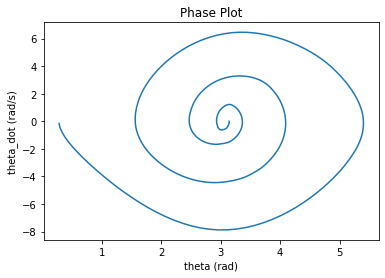

In [12]:
_ = plt.plot(theta, theta_dot)
_ = plt.xlabel("theta (rad)")
_ = plt.ylabel("theta_dot (rad/s)")
_ = plt.title("Phase Plot")

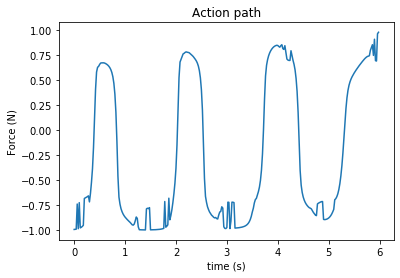

In [13]:
_ = plt.plot(t, us)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Force (N)")
_ = plt.title("Action path")

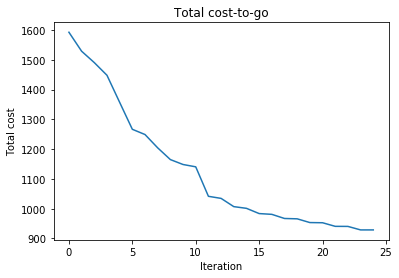

In [14]:
_ = plt.plot(J_hist)
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Total cost")
_ = plt.title("Total cost-to-go")